In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

2024-01-10 17:11:45.349303: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-10 17:11:45.349509: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-10 17:11:45.352502: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-10 17:11:45.363953: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-10 17:11:46.615608: W tensorflow/compiler/tf2

# 各パス指定

In [2]:
dataset = 'model/two_hands_keypoint_classifier/two_hands_keypoint.csv'
model_save_path = 'model/two_hands_keypoint_classifier/two_hands_keypoint_classifier.hdf5'

# 分類数設定

In [3]:
NUM_CLASSES = 6

# 学習データ読み込み

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2 * 2, )),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                6800      
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 40)                3240      
                                                                 
 dropout_1 (Dropout)         (None, 40)                0         
                                                                 
 dense_2 (Dense)             (None, 20)                820       
                                                                 
 dropout_2 (Dropout)         (None, 20)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                2

In [9]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


16/28 [================>.............] - ETA: 0s - loss: 1.6588 - accuracy: 0.2783 
Epoch 1: saving model to model/two_hands_keypoint_classifier/two_hands_keypoint_classifier.hdf5
28/28 [==============================] - 2s 16ms/step - loss: 1.5575 - accuracy: 0.3184 - val_loss: 1.1465 - val_accuracy: 0.4286
Epoch 2/1000
28/28 [==============================] - ETA: 0s - loss: 1.1081 - accuracy: 0.5126

/tmp/myenv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: saving model to model/two_hands_keypoint_classifier/two_hands_keypoint_classifier.hdf5
28/28 [==============================] - 0s 9ms/step - loss: 1.1081 - accuracy: 0.5126 - val_loss: 0.6968 - val_accuracy: 0.8333
Epoch 3/1000
26/28 [==========================>...] - ETA: 0s - loss: 0.7575 - accuracy: 0.6650
Epoch 3: saving model to model/two_hands_keypoint_classifier/two_hands_keypoint_classifier.hdf5
28/28 [==============================] - 0s 9ms/step - loss: 0.7534 - accuracy: 0.6657 - val_loss: 0.3479 - val_accuracy: 0.9881
Epoch 4/1000
28/28 [==============================] - ETA: 0s - loss: 0.5350 - accuracy: 0.7993
Epoch 4: saving model to model/two_hands_keypoint_classifier/two_hands_keypoint_classifier.hdf5
28/28 [==============================] - 0s 10ms/step - loss: 0.5350 - accuracy: 0.7993 - val_loss: 0.2282 - val_accuracy: 0.9770
Epoch 5/1000
14/28 [==============>...............] - ETA: 0s - loss: 0.4421 - accuracy: 0.8438
Epoch 5: saving model to model/two_

In [12]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

 1/10 [==>...........................] - ETA: 0s - loss: 2.8670e-04 - accuracy: 1.0000

10/10 [==============================] - 0s 4ms/step - loss: 0.0071 - accuracy: 0.9991


In [13]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [14]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 123ms/step
[3.1548695e-18 4.7190152e-10 7.6304950e-14 8.8033448e-32 7.5937376e-24
 1.0000000e+00]
5


# 混同行列

37/37 [==============================] - 0s 2ms/step


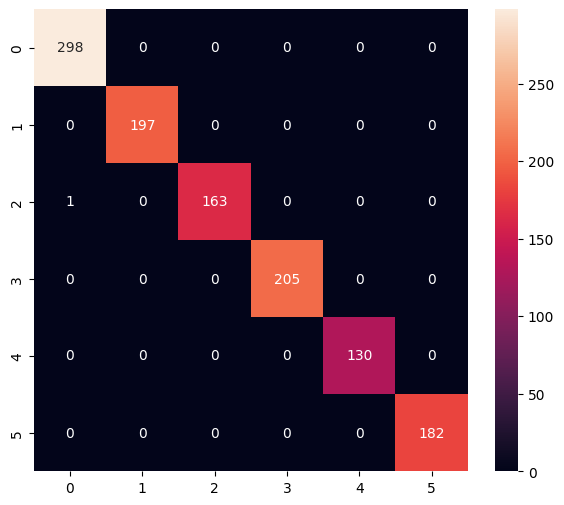

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       298
           1       1.00      1.00      1.00       197
           2       1.00      0.99      1.00       164
           3       1.00      1.00      1.00       205
           4       1.00      1.00      1.00       130
           5       1.00      1.00      1.00       182

    accuracy                           1.00      1176
   macro avg       1.00      1.00      1.00      1176
weighted avg       1.00      1.00      1.00      1176



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [16]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

/tmp/myenv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
# モデルを変換(量子化)
tflite_save_path = 'model/two_hands_keypoint_classifier/two_hands_keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpkhxzg4f4/assets


INFO:tensorflow:Assets written to: /tmp/tmpkhxzg4f4/assets
2024-01-10 17:12:09.230473: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-10 17:12:09.230569: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-10 17:12:09.231082: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpkhxzg4f4
2024-01-10 17:12:09.233047: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-10 17:12:09.233073: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpkhxzg4f4
2024-01-10 17:12:09.236712: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-01-10 17:12:09.237964: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-01-10 17:12:09.295291: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

17816

# 推論テスト

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [19]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 1.92 ms, sys: 0 ns, total: 1.92 ms
Wall time: 1.6 ms


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[3.5262846e-18 4.9809373e-10 8.3476764e-14 1.0830529e-31 8.8991375e-24
 1.0000000e+00]
5
